In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Load data
df_white = pd.read_csv('winequality-white.csv', delimiter=';')
df_red = pd.read_csv('winequality-red.csv')

df = df_white #pd.concat([df_white, df_red])

# Create a quality label (low, medium, high) based on quality score
df['quality_label'] = df['quality'].apply(lambda x: 'Poor' if x < 5 else 'Average' if x <= 7 else 'High')

# Encode 'quality_label' to numerical values
label_enc = LabelEncoder()
df['quality_label'] = label_enc.fit_transform(df['quality_label'])

df = df.drop_duplicates()

# Separate the data into features and target
X = df.drop(['quality', 'quality_label'], axis=1).to_numpy()
y = df['quality_label'].to_numpy()

In [21]:
# # RandomForest
model = RandomForestClassifier(class_weight="balanced", min_samples_split=2, max_depth=20, n_estimators=100, random_state=42)
rb_scaler = RobustScaler()

# Split the data into training and testing sets FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the data after to prevent data leakage
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

In [22]:
# GridSearchCV for hyperparameter tuning
param_grid = {
    "criterion": ["gini", "entropy"],
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [23]:
accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f'Accuracy: {accuracy*100:.2f} %')

Accuracy: 92.26 %


In [24]:
print('Encoded Quality Labels:\n', dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))
print('\n', classification_report(y_test, best_model.predict(X_test)))

Encoded Quality Labels:
 {'Average': 0, 'High': 1, 'Poor': 2}

               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1096
           1       0.00      0.00      0.00        41
           2       0.56      0.10      0.16        52

    accuracy                           0.92      1189
   macro avg       0.49      0.36      0.37      1189
weighted avg       0.88      0.92      0.89      1189



In [25]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.92432432 0.92072072 0.92418773 0.92418773 0.92779783]
Mean cross-validation score: 0.9242436660487202


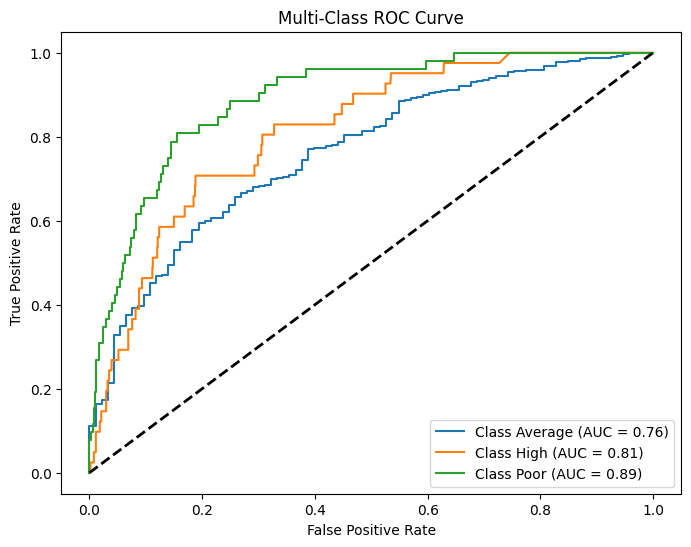

In [26]:
# Convert y_test and y_pred to binary format for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encode labels
y_score = best_model.predict_proba(X_test)  # Get probability scores for each class

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_enc.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


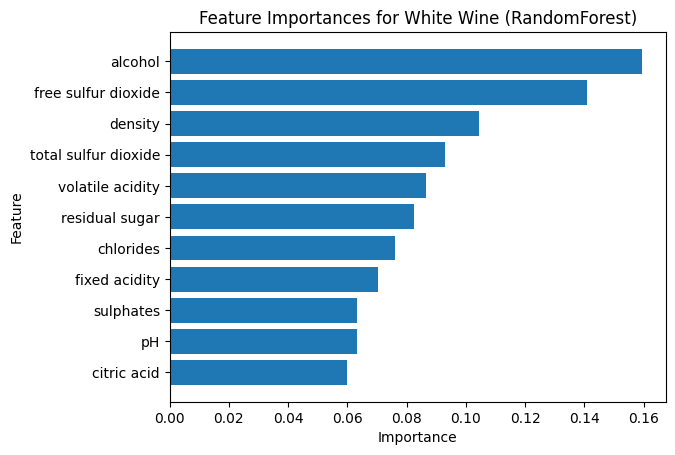

In [27]:
feature_names = df.columns
feature_names = feature_names.drop(['quality', 'quality_label'])

feature_importance = best_model.feature_importances_

feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

plt.barh(feat_importance_df['Feature'][::-1], feat_importance_df['Importance'][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances for White Wine (RandomForest)")
plt.show()